# ASR APIs & Models Testing and Comparison
- In this notebook I will show <b>how to transcribe audio by using a variety of ASR - Automatic Speech Recognition APIs and models</b>  
- ASR/STT takes an audio stream or audio buffer as input and returns one or more text transcripts, along with additional optional metadata   
- We will use following ASR APIs/models:  
-- OpenAI's [Whisper](https://github.com/openai/whisper)   
-- Python package [SpeechRecognition](https://github.com/Uberi/speech_recognition)      
-- [Speechmatics](https://www.speechmatics.com/)    
-- [Deepgram](https://deepgram.com/)    
-- Meta's [Seamlessm4t](https://github.com/facebookresearch/seamless_communication.git)    
-- Nvidias [Nemo](https://github.com/NVIDIA/NeMo/)     


In [ ]:
# Install jiwer for calculating word error rate (WER) for ASR accuracy comparison!
# Uncomment below to install jiwer
!python3 -m pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.9 MB/s eta 0:00:00


In [ ]:
import io, re
import jiwer
import json
import time
import requests
import pandas as pd
import IPython.display as ipd

## Compare All ASRs Like-for-Like By Using An Audio Sample Clip

In [ ]:
!wget https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav -O /content/LJ_eng.wav
sample = "/content/LJ_eng.wav" #audio_sample
ipd.Audio(sample)

--2024-06-19 05:44:17--  https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.102, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485430 (474K) [audio/x-wav]
Saving to: ‘/content/LJ_eng.wav’

/content/LJ_eng.wav 100%[===================>] 474.05K  --.-KB/s    in 0.007s  

2024-06-19 05:44:17 (70.3 MB/s) - ‘/content/LJ_eng.wav’ saved [485430/485430]



## 1. Whisper
- OpenAI's Robust Speech Recognition via Large-Scale Weak Supervision   
- They've open sourced the model code: https://github.com/openai/whisper   
- OpenAI has taken  a data-centric approach: it is a normal transformer architecture but they've used a very large and diverse dataset (even across multiple languages, **non-English counts for 1/3 of training data!**), so it is very robust especially in <b>Zero-shot Learning</b>.   

### Install Whisper Step-by-Step Instructions (Tested & Verified on MacBook)

1.1 create a virtual env., open a command line and type: `conda create -n vva python=3.9`  
1.2 activate the virtual env: `conda activate vva`  
1.3 create a new folder in your MacBook drive, e.g. `mkdir VVA_AIChatbot`   
1.4 Install the openai whisper:   
As per https://github.com/openai/whisper, the following command will pull and install the latest commit from this repository, along with its Python dependencies:  
`pip install git+https://github.com/openai/whisper.git`     
1.5 install Jupyter notebook library: `pip install jupyter notebook`  
1.6 In command line, start notebook by type in: `jupyter notebook`  
1.7 Click button ’New’ —> ‘Python3’ on upper-right corner of the menu to create a new notebook  
1.8 install/update brew on MacBook:   
/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"  
Then:   
`brew update-reset`     
  
1.9 change permission:   
You should change the ownership of these directories to your user.  
  `sudo chown -R $(whoami) /usr/local/share/zsh /usr/local/share/zsh/site-functions`  
  
And make sure that your user has write permission.  
  `chmod u+w /usr/local/share/zsh /usr/local/share/zsh/site-functions`  

1.10 install ffmpeg:   
`brew install ffmpeg`  

1.11 install rust as well:  
`pip install setuptools-rust`  

1.12 copy & paste the code from repo to run the notebook to use Whisper to transcribe any audio/video file  

Done!  

### Install Whisper on Centos Instructions (Centos is open-sourced version of RedHat Linux)
- Following GitHub set-up steps:   https://github.com/openai/whisper
- Install ffmpeg on Centos:   
`sudo yum install epel-release   
sudo yum localinstall --nogpgcheck https://download1.rpmfusion.org/free/el/rpmfusion-free-release-7.noarch.rpm   
sudo yum install ffmpeg ffmpeg-devel   
ffmpeg -version`  

### Run whisper in command line

- The default setting (which selects the 'small' model) works well for transcribing English  
- If seeing the error of "CUDA out of memory" in PyTorch, use 'tiny' model instead:  
- https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch   
`whisper audio_sample.wav --model tiny`  

- Note use `--language`  and `--model` to specify other languages and models (default is English and small model)
- Adding `--task translate` will translate the transcribed speech into English (i.e. **Speech Translation**):   
`whisper japanese.wav --language Japanese --model base --task translate`  

In [2]:
filepaths = [
    "/content/Recording.m4a",
    "/content/Recording (2).m4a",
    "/content/Recording (3).m4a",
    "/content/Recording (4).m4a",
    "/content/Recording (5).m4a",
    "/content/Recording (6).m4a",
    "/content/Recording (7).m4a",
    "/content/Recording (8).m4a",
    "/content/Recording (9).m4a",
    "/content/Recording (10).m4a",
    "/content/Recording (11).m4a",
    "/content/Recording (12).m4a",
    "/content/Recording (13).m4a",
    "/content/Recording (14).m4a",
    "/content/Recording (15).m4a",
    "/content/Recording (16).m4a",
    "/content/Recording (17).m4a",
    "/content/Recording (18).m4a",
    "/content/Recording (19).m4a",
    "/content/Recording (20).m4a"

]

### Run whisper programatically in Python

In [ ]:
#filepath="/content/OSR_us_000_0010_8k.wav"
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-ww_5yqtd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-ww_5yqtd
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-

In [ ]:
import whisper
import time

model = whisper.load_model("small")
results = {}

# Process each file
for filepath in filepaths:
    start = time.time()
    result = model.transcribe(filepath)
    end = time.time()
    whisper_latency = end - start
    whisper_transcript = result["text"]

    # Store the results in the dictionary
    results[filepath] = {
        "whisper_transcript": whisper_transcript,
        "whisper_latency": whisper_latency
    }

# Print the results
for filepath, result in results.items():
    print(f'File: {filepath}')
    print(f'Whisper transcript:\n{result["whisper_transcript"]}')
    print(f'Whisper latency: {result["whisper_latency"]} seconds\n')

File: /content/Recording.m4a
Whisper transcript:
 What is the best way to diversify my portfolio?
Whisper latency: 0.5647969245910645 seconds

File: /content/Recording (2).m4a
Whisper transcript:
 How much should I be saving for retirement each month?
Whisper latency: 0.5112690925598145 seconds

File: /content/Recording (3).m4a
Whisper transcript:
 What are the benefits of investing in mutual funds versus individual stocks?
Whisper latency: 0.5580134391784668 seconds

File: /content/Recording (4).m4a
Whisper transcript:
 Can you explain the difference between Roth IRA and a traditional IRA?
Whisper latency: 0.57279372215271 seconds

File: /content/Recording (5).m4a
Whisper transcript:
 What is my current risk tolerance and how should it impact my investment strategy?
Whisper latency: 0.617318868637085 seconds

File: /content/Recording (6).m4a
Whisper transcript:
 How can I protect my investments during a market down-down?
Whisper latency: 0.5543584823608398 seconds

File: /content/Reco

In [ ]:
import json
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

#### Below is an example usage of `whisper.detect_language()` and `whisper.decode()` which provide lower-level access to the model.

In [ ]:
import whisper

model = whisper.load_model("base")
start = time.time()
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio(sample)
audio = whisper.pad_or_trim(audio)
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)
# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")
# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)
# print the recognized text
print(result.text)
end = time.time()
whisper_latency = end-start

print(f'Whisper latency: {whisper_latency} seconds')

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 127MiB/s]


Detected language: en
The examination and testimony of the experts enabled the commission to conclude that five shots may have been fired.
Whisper latency: 0.5053346157073975 seconds


## 2. Open-Source Python Package SpeechRecognition
- It is an opens-source Python library for performing speech recognition, with support for several engines and APIs, online and offline, including:   
-- CMU Sphinx (works offline)  
-- Google Cloud Speech API  
-- Wit.ai  
-- Microsoft Azure Speech  
-- Microsoft Bing Voice Recognition (Deprecated)  
-- Houndify API  
-- IBM Speech to Text  
-- Snowboy Hotword Detection (works offline)  
-- Tensorflow  
-- Vosk API (works offline)  
-- OpenAI Whisper (works offline)  
-- Whisper API  

In [ ]:
#Install the library
!pip install SpeechRecognition

import speech_recognition as sr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
!pip install pyttsx3


In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0
!pip install PyAudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 2s (123 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpac

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
import speech_recognition as sr
import time
import os

# Convert MP4A to WAV format
def convert_to_wav(filepath):
    audio = AudioSegment.from_file(filepath)
    wav_path = os.path.splitext(filepath)[0] + ".wav"
    audio.export(wav_path, format="wav")
    return wav_path


# Dictionary to store results
sr_results = {}

# Initialize recognizer class (for recognizing the speech)
r = sr.Recognizer()

# Process each file
for filepath in filepaths:
    try:
        # Convert MP4A to WAV
        wav_path = convert_to_wav(filepath)

        # Reading Audio file as source
        with sr.AudioFile(wav_path) as source:
            audio_text = r.listen(source)
        start = time.time()
        # Recognize the speech in the audio
        sr_google_transcript = r.recognize_google(audio_text)
        end = time.time()
        sr_google_latency = end - start

        # Store the results in the dictionary
        sr_results[filepath] = {
            "transcript": sr_google_transcript,
            "latency": sr_google_latency
        }
    except sr.UnknownValueError:
        print(f"Google Speech Recognition could not understand audio in file {filepath}")
        results[filepath] = {
            "transcript": None,
            "latency": None,
            "error": "Google Speech Recognition could not understand audio"
        }
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service for file {filepath}; {e}")
        results[filepath] = {
            "transcript": None,
            "latency": None,
            "error": f"Could not request results from Google Speech Recognition service; {e}"
        }
    except Exception as e:
        print(f"An error occurred while processing file {filepath}; {e}")
        results[filepath] = {
            "transcript": None,
            "latency": None,
            "error": f"An error occurred while processing file; {e}"
        }

# Print the results
for filepath, result in sr_results.items():
    print(f'File: {filepath}')
    if result["transcript"]:
        print(f'Google transcript:\n{result["transcript"]}')
        print(f'Google latency: {result["latency"]} seconds\n')
    else:
        print(f'Error: {result["error"]}\n')



File: /content/Recording.m4a
Google transcript:
what is the best way to diversify my portfolio
Google latency: 0.876032829284668 seconds

File: /content/Recording (2).m4a
Google transcript:
how much should I be saving for retirement each month
Google latency: 1.1272292137145996 seconds

File: /content/Recording (3).m4a
Google transcript:
what are the benefits of investing in mutual funds versus individual stocks
Google latency: 1.5095880031585693 seconds

File: /content/Recording (4).m4a
Google transcript:
can you explain the difference between a Roth IRA and a traditional IRA
Google latency: 1.7840235233306885 seconds

File: /content/Recording (5).m4a
Google transcript:
is my current this tolerance and how should it impact my investment strategy
Google latency: 1.7589366436004639 seconds

File: /content/Recording (6).m4a
Google transcript:
how can I protect my investments during a market downturn
Google latency: 0.8618273735046387 seconds

File: /content/Recording (7).m4a
Google trans

## 3. Speechmatics
- Commerical ASR service, not open-source

#### Create functions for using the API

In [ ]:
# For Speechmatics API
url = 'https://asr.api.speechmatics.com/v2/jobs/'
SM_API_KEY = 'QGtJAEygd95XblN6DaBpuo8rujSPfPsb'
headers = {"Authorization": f"Bearer {SM_API_KEY}"}

In [ ]:
def send_request(file):
    """
    input: file path
    output: response id

    function to send the file to be processed to the Speechmatics API and get the reponse ID as output
    """
    form = {"config": (None, '{"type": "transcription","transcription_config": { "language": "en" }}'),
            "data_file": (file, open(file, 'rb'))}
    x = requests.post(url, headers=headers, files=form)
    response_id = json.loads(x.text[:-1])['id']
    return response_id

In [ ]:
def get_transcript(response_id, sleep=10):
    """
    input: response id
    output: transcript

    function to request transcript with the response ID
    function would keep retrying until the transcript is ready (when status code is 200)
    - it shows 404 when transcript is not ready
    """
    transcript_url = f"https://asr.api.speechmatics.com/v2/jobs/{response_id}/transcript"
    response = requests.get(transcript_url , headers=headers)
    count = 1
    while response.status_code != 200:
        count += 1
        time.sleep(sleep)
        response = requests.get(transcript_url , headers=headers)
    response_test = json.loads(response.text)
    string = ''
    for word in response_test['results']:
        string += f" {word['alternatives'][0]['content']}"
    return string.lower(), count

In [ ]:
sm_results = {}

# Process each file
for filepath in filepaths:
    try:
        start = time.time()
        response_id = send_request(filepath)
        sm_transcript, retries = get_transcript(response_id)
        end = time.time()
        sm_latency = end - start

        # Store the results in the dictionary
        sm_results[filepath] = {
            "transcript": sm_transcript,
            "retries": retries,
            "latency": sm_latency
        }
    except Exception as e:
        print(f"An error occurred while processing file {filepath}; {e}")
        sm_results[filepath] = {
            "transcript": None,
            "retries": None,
            "latency": None,
            "error": f"An error occurred while processing file; {e}"
        }

# Print the results
for filepath, result in sm_results.items():
    print(f'File: {filepath}')
    if result["transcript"]:
        print(f'Speechmatics transcript:\n{result["transcript"]}')
        print(f'Retries: {result["retries"]}')
        print(f'Speechmatics latency: {result["latency"]} seconds\n')
    else:
        print(f'Error: {result["error"]}\n')

File: /content/Recording.m4a
Speechmatics transcript:
 what is the best way to diversify my portfolio ?
Retries: 3
Speechmatics latency: 23.309850215911865 seconds

File: /content/Recording (2).m4a
Speechmatics transcript:
 what should i be saving for retirement ? each month .
Retries: 2
Speechmatics latency: 12.66263222694397 seconds

File: /content/Recording (3).m4a
Speechmatics transcript:
 what are the benefits of investing in mutual funds versus individual stocks ?
Retries: 2
Speechmatics latency: 12.608481168746948 seconds

File: /content/Recording (4).m4a
Speechmatics transcript:
 can you explain the difference between a roth ira and a traditional ira ?
Retries: 2
Speechmatics latency: 12.607931137084961 seconds

File: /content/Recording (5).m4a
Speechmatics transcript:
 this is my current risk tolerance and how should it impact my investment strategy ?
Retries: 2
Speechmatics latency: 12.590136051177979 seconds

File: /content/Recording (6).m4a
Speechmatics transcript:
 how can

In [ ]:
import json
with open("sm_results.json", "w") as f:
    json.dump(sm_results, f, indent=4)

## 4. Deepgram
- Another commercial spealist in advanced speech recognition services

In [ ]:
# Uncomment to download the Deepgram
!python3 -m pip install deepgram-sdk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.9 MB/s eta 0:00:00


In [ ]:
from deepgram import DeepgramClient, PrerecordedOptions
import asyncio, json
from datetime import datetime

In [ ]:
DG_API_KEY = 'b8829a89584a915cda3d3d5d375dbb43db097352' # API Key generated from Deepgram
MIMETYPE = 'audio/wav'

In [ ]:
deepgram = DeepgramClient(DG_API_KEY)

In [ ]:
import json
import time
import os
from pydub import AudioSegment
from deepgram import Deepgram, PrerecordedOptions

deepgram = DeepgramClient(DG_API_KEY)

# Convert to WAV format if needed
def convert_to_wav(filepath):
    audio = AudioSegment.from_file(filepath)
    wav_path = os.path.splitext(filepath)[0] + ".wav"
    audio.export(wav_path, format="wav")
    return wav_path


# Dictionary to store results
dg_results = {}

# Process each file
for filepath in filepaths:
    try:
        # Convert to WAV
        wav_path = convert_to_wav(filepath)

        # Transcribe using Deepgram
        start = time.time()
        with open(wav_path, 'rb') as buffer_data:
            payload = {'buffer': buffer_data}

            options = PrerecordedOptions(
                smart_format=True, model="nova-2", language="en-US"
            )

            response = deepgram.listen.prerecorded.v('1').transcribe_file(payload, options)

            json_response = response.to_json(indent=4)

            # Parse JSON response into a dictionary
            response_dict = json.loads(json_response)

            # Access the "results" section
            results = response_dict.get("results", {})

            # Access the "channels" list
            channels = results.get("channels", [])

            # Assuming there's only one channel, you can access its first element
            if channels:
                channel = channels[0]

                # Access the first alternative
                first_alternative = channel.get("alternatives", [])[0]

                # Access the transcript and confidence
                transcript = first_alternative.get("transcript", "")
                dg_transcript = transcript
                confidence = first_alternative.get("confidence", "")
                end = time.time()

                # Access the latency information
                dg_latency = end - start

                # Store the results in the dictionary
                dg_results[filepath] = {
                    "transcript": dg_transcript,
                    "confidence": confidence,
                    "latency": dg_latency
                }
    except Exception as e:
        print(f"An error occurred while processing file {filepath}; {e}")
        dg_results[filepath] = {
            "transcript": None,
            "confidence": None,
            "latency": None,
            "error": f"An error occurred while processing file; {e}"
        }

# Print the results
for filepath, result in dg_results.items():
    print(f'File: {filepath}')
    if result["transcript"]:
        print(f'Transcription:\n{result["transcript"]}')
        print(f'Confidence: {result["confidence"]}')
        print(f'Latency: {result["latency"]} seconds\n')
    else:
        print(f'Error: {result["error"]}\n')


File: /content/Recording.m4a
Transcription:
What is the best way to diversify my portfolio?
Confidence: 0.9931132
Latency: 5.0641796588897705 seconds

File: /content/Recording (2).m4a
Transcription:
How much should I be saving for retirement each month?
Confidence: 0.99571854
Latency: 2.3240272998809814 seconds

File: /content/Recording (3).m4a
Transcription:
What are the benefits of investing in mutual funds versus individual stocks?
Confidence: 0.99722904
Latency: 2.3931632041931152 seconds

File: /content/Recording (4).m4a
Transcription:
Can you explain the difference between, Roth IRA and a traditional IRA?
Confidence: 0.9903133
Latency: 2.520038604736328 seconds

File: /content/Recording (5).m4a
Transcription:
What is my current risk tolerance, and how should it impact my investment strategy?
Confidence: 0.9969363
Latency: 2.2565767765045166 seconds

File: /content/Recording (6).m4a
Transcription:
How can I protect my investments during a market downturn?
Confidence: 0.998393
Late

In [ ]:
import json
with open("dg_results.json", "w") as f:
    json.dump(dg_results, f, indent=4)

# 5.SeamlessM4T

Meta’s SeamlessM4T-Massively Multilingual & Multimodal Machine Translation model.
It is made publicly available under CC BY-NC 4.0 licence — a non-commercial licence which means that people can remix, adapt and build on it but cannot use it for commercial purposes.
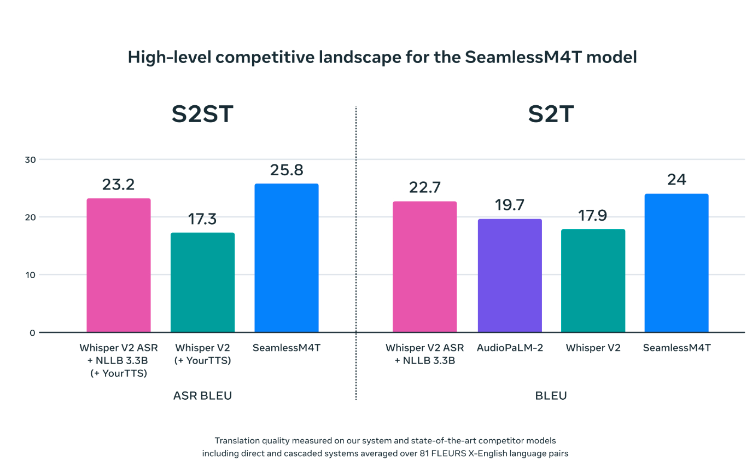
Source-[Meta AI Blog](https://ai.meta.com/blog/seamless-m4t/)

In [ ]:
!pip install fairseq2
!pip install pydub sentencepiece
!pip install git+https://github.com/facebookresearch/seamless_communication.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: nvidia-ncc

  Cloning https://github.com/facebookresearch/seamless_communication.git to /tmp/pip-req-build-kzfe791e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/seamless_communication.git /tmp/pip-req-build-kzfe791e
  Resolved https://github.com/facebookresearch/seamless_communication.git to commit 81aee56003022af2c0bc05203bfbd598de73d899
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.

In [ ]:
import io
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import mmap
import numpy
import soundfile
import torch
from collections import defaultdict
from IPython.display import Audio, display
from pathlib import Path
from pydub import AudioSegment
from seamless_communication.inference import Translator
from seamless_communication.streaming.dataloaders.s2tt import SileroVADSilenceRemover

In [ ]:
# Initialize a Translator object with a multitask model, vocoder on the GPU.

model_name = "seamlessM4T_v2_large"
vocoder_name = "vocoder_v2" if model_name == "seamlessM4T_v2_large" else "vocoder_36langs"

translator = Translator(
    model_name,
    vocoder_name,
    device=torch.device("cuda:0"),
    dtype=torch.float16,
)

100%|██████████| 8.45G/8.45G [00:54<00:00, 166MB/s] 
100%|██████████| 360k/360k [00:00<00:00, 19.5MB/s]
100%|██████████| 4.93M/4.93M [00:00<00:00, 206MB/s]
Using the cached tokenizer of seamlessM4T_v2_large. Set `force` to `True` to download again.
100%|██████████| 160M/160M [00:00<00:00, 196MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
import time
import os
from pydub import AudioSegment

# Convert to WAV format if needed
def convert_to_wav(filepath):
    audio = AudioSegment.from_file(filepath)
    wav_path = os.path.splitext(filepath)[0] + ".wav"
    audio.export(wav_path, format="wav")
    return wav_path

tgt_langs = ["eng"]
m4t_results = {}

# Process each file
for filepath in filepaths:
    try:
        # Convert to WAV
        wav_path = convert_to_wav(filepath)

        for tgt_lang in tgt_langs:
            start = time.time()
            text_output, _ = translator.predict(
                input=wav_path,
                task_str="asr",
                 tgt_lang=tgt_lang,
            )
            end = time.time()
            latency = end - start

            # Store the results in the dictionary
            m4t_results[filepath] = {
                "transcript": text_output[0],
                "latency": latency,
                "tgt_lang": tgt_lang
            }

            print(f"File: {wav_path}")
            print(f"Transcribed text in {tgt_lang}: {text_output[0]}")
            print(f"Latency: {latency} seconds\n")
    except Exception as e:
        print(f"An error occurred while processing file {filepath}; {e}")
        m4t_results[filepath] = {
            "transcript": None,
            "latency": None,
            "tgt_lang": tgt_lang,
            "error": f"An error occurred while processing file; {e}"
        }

# Print all results
for filepath, result in m4t_results.items():
    print(f'File: {filepath}')
    if result["transcript"] is None:
        print(f'Error: {result["error"]}\n')
    else:
        print(f'Transcription: {result["transcript"]}')
        print(f'Target Language: {result["tgt_lang"]}')
        print(f'Latency: {result["latency"]} seconds\n')


File: /content/Recording.wav
Transcribed text in eng: It's the first time I've ever been to a place like this.
Latency: 0.5484540462493896 seconds

File: /content/Recording (2).wav
Transcribed text in eng: What's the matter with you? You're so old.
Latency: 0.5542192459106445 seconds

File: /content/Recording (3).wav
Transcribed text in eng: He is a member of the Board of Trustees of the National Association for the Advancement of Colored People.
Latency: 0.8737452030181885 seconds

File: /content/Recording (4).wav
Transcribed text in eng: Can you explain the difference between a rotary and a traditional rary?
Latency: 0.7223248481750488 seconds

File: /content/Recording (5).wav
Transcribed text in eng: What is my current risk tolerance and how will it affect my investment strategy?
Latency: 0.6408898830413818 seconds

File: /content/Recording (6).wav
Transcribed text in eng: On the contrary, it keeps the water in the bathroom clean.
Latency: 0.5554027557373047 seconds

File: /content/

In [ ]:
import json
import time
import os
from pydub import AudioSegment

# Convert to WAV format if needed
def convert_to_wav(filepath):
    audio = AudioSegment.from_file(filepath)
    wav_path = os.path.splitext(filepath)[0] + ".wav"
    audio.export(wav_path, format="wav")
    return wav_path


tgt_langs = ["eng"]
m4t_results = {}

# Process each file
for filepath in filepaths:
    try:
        # Convert to WAV
        wav_path = convert_to_wav(filepath)

        for tgt_lang in tgt_langs:
            start = time.time()
            text_output, _ = translator.predict(
                input=wav_path,
                task_str="asr",
                tgt_lang=tgt_lang,
            )
            end = time.time()
            latency = end - start

            # Store the results in the dictionary
            m4t_results[filepath] = {
                "transcript": text_output[0],
                "latency": latency,
                "tgt_lang": tgt_lang
            }
    except Exception as e:
        m4t_results[filepath] = {
            "transcript": str(e),  # Convert exception to string
            "latency": None,
            "tgt_lang": tgt_lang,
            "error": f"An error occurred while processing file; {e}"
        }

# Convert results to JSON
json_results = json.dumps(m4t_results, default=str, indent=4)

# Print or save JSON
print(json_results)

# If you want to save the JSON to a file
with open("m4t_results.json", "w") as json_file:
    json_file.write(json_results)


{
    "/content/Recording.m4a": {
        "transcript": "It's the first time I've ever been to a place like this.",
        "latency": 0.5589137077331543,
        "tgt_lang": "eng"
    },
    "/content/Recording (2).m4a": {
        "transcript": "What's the matter with you? You're so old.",
        "latency": 0.41263461112976074,
        "tgt_lang": "eng"
    },
    "/content/Recording (3).m4a": {
        "transcript": "He is a member of the Board of Trustees of the National Association for the Advancement of Colored People.",
        "latency": 0.607306957244873,
        "tgt_lang": "eng"
    },
    "/content/Recording (4).m4a": {
        "transcript": "Can you explain the difference between a rotary and a traditional rary?",
        "latency": 0.6435480117797852,
        "tgt_lang": "eng"
    },
    "/content/Recording (5).m4a": {
        "transcript": "What is my current risk tolerance and how will it affect my investment strategy?",
        "latency": 0.7026801109313965,
        "t

Example of translating a language into another

In [ ]:
tgt_langs = ("eng")
for tgt_lang in tgt_langs:
  in_file = f"/content/OSR_us_000_0010_8k.wav"


  text_output, _ = translator.predict(
        input=in_file,
        task_str="asr",
        tgt_lang=tgt_lang,
    )
  print(f"Transcribed text in {tgt_lang}: {text_output[0]}")
  print()


Transcribed text in eng: the birch canoe is smooth on the smooth planks blue of the sea to a dark blue background it is easy to tell the depth of a well these days a city made is a rare dish rice is often served in round bowls the juice of lemons made fine punch the box was thrown beside the punch chute the hot springs hot corn and garbage four hours of steady work fisters a large size stockings is hard to sell

Transcribed text in hin: इन दिनों सिटी मेड एक दुर्लभ व्यंजन है। चावल अक्सर गोल कटोरे में परोसा जाता है। नींबू का रस ठीक पंच में बनाया जाता है। बॉक्स को पंच चट के बगल में फेंक दिया जाता है।



#6.ASR_with_Nemo

"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect


NOTE: User is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
"""
# If you're using Google Colab and not running locally, run this cell.


```
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2
```


```
## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

```

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""

exit()






In [ ]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2
## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=70787e326cf6956921ee81a65831b27fee2d139687886c54a6d3de717da17acc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 45 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additi

In [ ]:
import os
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

Potting a spectrogram, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file. A spectrogram (which can be viewed as a heat map) is a good way of seeing how the strengths of various frequencies in the audio vary over time,

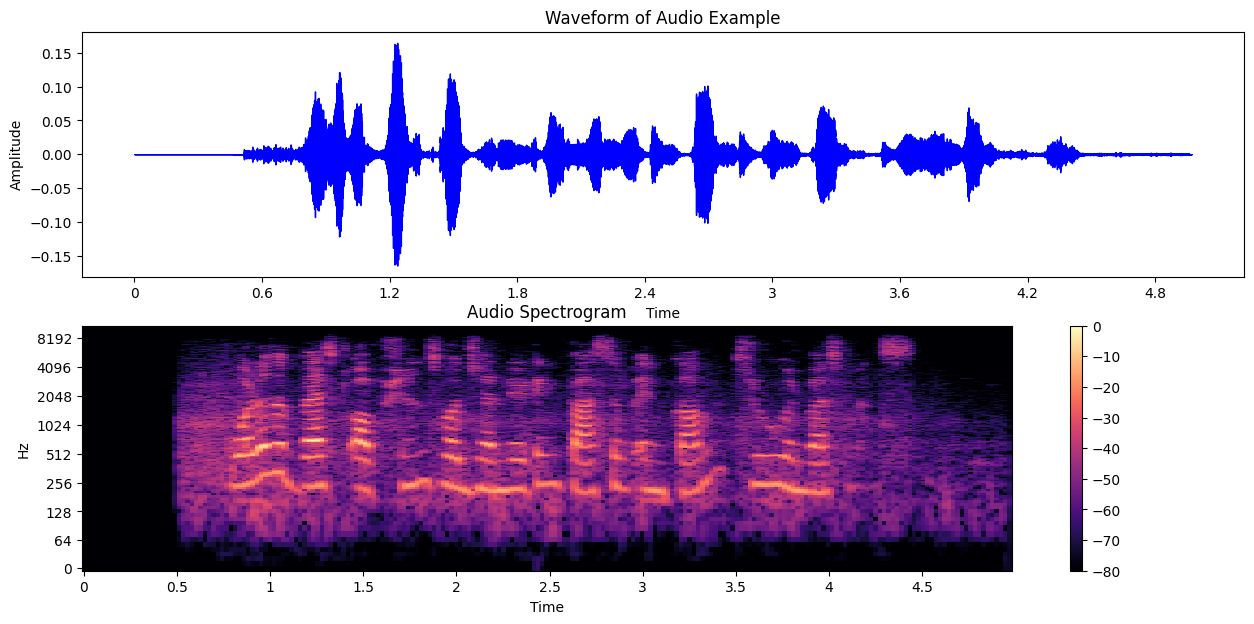

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Plot waveform
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')
librosa.display.waveshow(audio, color='blue')

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Plot spectrogram
plt.subplot(2,1,2)
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

In [ ]:
import os
import time
from pydub import AudioSegment
import nemo.collections.asr as nemo_asr

# Function to convert MP4A to WAV and force mono
def convert_mp4a_to_wav(input_filepath, output_filepath=None):
    audio = AudioSegment.from_file(input_filepath, format="mp4")
    audio = audio.set_channels(1)  # Convert to mono
    if output_filepath is None:
        output_filepath = os.path.splitext(input_filepath)[0] + ".wav"
    audio.export(output_filepath, format="wav")
    return output_filepath

# Directory to save WAV files
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)



# Convert MP4A files to WAV and get the list of WAV file paths
wav_paths = [convert_mp4a_to_wav(filepath) for filepath in filepaths]

# Initialize NeMo model
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

# Process each WAV file
nm_results = {}
start = time.time()

for fname in wav_paths:
    try:
        transcription = quartznet.transcribe(audio=[fname])[0]
        end = time.time()
        nm_latency = end - start
        nm_results[fname] = {
            "transcript": transcription,
            "latency": nm_latency
        }
        print(f'NEMO transcript for {fname}:\n{transcription}')
        print(f'NEMO latency: {nm_latency} seconds\n')
    except Exception as e:
        print(f'Error processing {fname}: {e}')
        nm_results[fname] = {
            "transcript": None,
            "latency": None,
            "error": str(e)
        }

# Optionally convert results to JSON
import json

json_results = json.dumps(nm_results, indent=4)
print(json_results)

# If you want to save the JSON to a file
with open("nemo_results.json", "w") as json_file:
    json_file.write(json_results)


[NeMo I 2024-06-19 10:47:33 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_2.0.0rc1/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2024-06-19 10:47:33 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.0.0rc1/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-06-19 10:47:33 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-06-19 10:47:35 features:305] PADDING: 16
[NeMo I 2024-06-19 10:47:35 save_restore_connector:263] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0rc1/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


NEMO transcript for /content/Recording.wav:
what is the best way to diversify my portfolio
NEMO latency: 0.7254095077514648 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


NEMO transcript for /content/Recording (2).wav:
muct should i be said for retirement each month
NEMO latency: 1.5499346256256104 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


NEMO transcript for /content/Recording (3).wav:
what are the benefits of investing in mucial funds versus individual stocks
NEMO latency: 2.4444806575775146 seconds



Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


NEMO transcript for /content/Recording (4).wav:
can you explain the difference between or rotari and a traditional aiary
NEMO latency: 3.4970123767852783 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


NEMO transcript for /content/Recording (5).wav:
is my current is tolerance and how should it impact my investment strategy
NEMO latency: 4.454627275466919 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


NEMO transcript for /content/Recording (6).wav:
how can i protect my investment during a market downturn
NEMO latency: 5.14487361907959 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


NEMO transcript for /content/Recording (7).wav:
further tax implications of selling my investments
NEMO latency: 5.85486102104187 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


NEMO transcript for /content/Recording (8).wav:
should i consider investing in real estate as part of my portfolio
NEMO latency: 6.715656757354736 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


NEMO transcript for /content/Recording (9).wav:
how often should i review and rebalance my investment portfolio
NEMO latency: 7.675013780593872 seconds



Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


NEMO transcript for /content/Recording (10).wav:
one of the best options for generating passive income through investments
NEMO latency: 9.039225816726685 seconds



Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


NEMO transcript for /content/Recording (11).wav:
can you help me understand the fees associated with my investment accounts
NEMO latency: 10.460928678512573 seconds



Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


NEMO transcript for /content/Recording (12).wav:
what are the potential risks and rewards of investing in crypticcurrency
NEMO latency: 11.951859712600708 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


NEMO transcript for /content/Recording (13).wav:
how do i set up an emergency fund and how much should it be
NEMO latency: 12.777255058288574 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


NEMO transcript for /content/Recording (14).wav:
one ore the advantages of using a robo advisor for managing my investments
NEMO latency: 13.707389116287231 seconds



Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


NEMO transcript for /content/Recording (15).wav:
ow do interest rate changes affect my bond investments
NEMO latency: 14.839755058288574 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


NEMO transcript for /content/Recording (16).wav:
is now a good time to invest in the stock market given my current economic condition
NEMO latency: 15.847141981124878 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


NEMO transcript for /content/Recording (17).wav:
what arso strategy for maximizing my for o one k contributions
NEMO latency: 16.74521780014038 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


NEMO transcript for /content/Recording (18).wav:
how can i make my investments aligned with my ethical values
NEMO latency: 17.601767778396606 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


NEMO transcript for /content/Recording (19).wav:
what is the difference between growth talks and balue stocks and which should i invest or
NEMO latency: 18.549708127975464 seconds



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

NEMO transcript for /content/Recording (20).wav:
wuth factors should i consider when choosing between different mutual funds
NEMO latency: 19.48908567428589 seconds

{
    "/content/Recording.wav": {
        "transcript": "what is the best way to diversify my portfolio",
        "latency": 0.7254095077514648
    },
    "/content/Recording (2).wav": {
        "transcript": "muct should i be said for retirement each month",
        "latency": 1.5499346256256104
    },
    "/content/Recording (3).wav": {
        "transcript": "what are the benefits of investing in mucial funds versus individual stocks",
        "latency": 2.4444806575775146
    },
    "/content/Recording (4).wav": {
        "transcript": "can you explain the difference between or rotari and a traditional aiary",
        "latency": 3.4970123767852783
    },
    "/content/Recording (5).wav": {
        "transcript": "is my current is tolerance and how should it impact my investment strategy",
        "latency": 4.45462727546

Loading json files of outputs

## A Like-for-like Transcription Accuracy Comparison Using WER (Word Error Rate)

In [ ]:
import json
import os
import re
import pandas as pd
from jiwer import wer

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def clean_transcript(transcript):
    transcript = transcript.lower()
    transcript = re.sub(r'[^a-z0-9\s]', '', transcript)
    transcript = re.sub(r'\s+', ' ', transcript).strip()
    return transcript

# List of JSON files
json_files = ["results.json", "google_sr_results.json", "sm_results.json", "dg_results.json", "m4t_results.json", "nemo_results.json"]

# Separate dictionaries to store results for each JSON file
results_transcripts_data = {}
google_sr_transcripts_data = {}
sm_transcripts_data = {}
dg_transcripts_data = {}
m4t_transcripts_data = {}
nemo_transcripts_data = {}

# Dictionary to map filenames to their respective dictionaries
file_to_dict = {
    "results.json": results_transcripts_data,
    "google_sr_results.json": google_sr_transcripts_data,
    "sm_results.json": sm_transcripts_data,
    "dg_results.json": dg_transcripts_data,
    "m4t_results.json": m4t_transcripts_data,
    "nemo_results.json": nemo_transcripts_data
}

# Ground truth questions
ground_truth_questions = [
    "What is the best way to diversify my investment portfolio?",
    "How much should I be saving for retirement each month?",
    "What are the benefits of investing in mutual funds versus individual stocks?",
    "Can you explain the difference between a Roth IRA and a traditional IRA?",
    "What is my current risk tolerance, and how should it impact my investment strategy?",
    "How can I protect my investments during a market downturn?",
    "What are the tax implications of selling my investments?",
    "Should I consider investing in real estate as part of my portfolio?",
    "How often should I review and rebalance my investment portfolio?",
    "What are the best options for generating passive income through investments?",
    "Can you help me understand the fees associated with my investment accounts?",
    "What are the potential risks and rewards of investing in cryptocurrency?",
    "How do I set up an emergency fund, and how much should it be?",
    "What are the advantages of using a robo-advisor for managing my investments?",
    "How do interest rate changes affect my bond investments?",
    "Is now a good time to invest in the stock market given my current economic condition?",
    "What are some strategies for maximizing my 401(k) contributions?",
    "How can I make my investments align with my ethical values?",
    "What is the difference between growth stocks and value stocks, and which should I invest in?",
    "What factors should I consider when choosing between different mutual funds?"
]

# Load data from JSON files
for json_file in json_files:
    results = load_json(json_file)
    target_dict = file_to_dict[json_file]
    for filepath, data in results.items():
        if "transcript" in data and data["transcript"] is not None:
            target_dict[filepath] = {
                "transcript": data["transcript"],
                "latency": data.get("latency", None)
            }

# Calculate WER for each file's transcript against the ground truth
wer_results = {}
latency_results = {}

for idx, question in enumerate(ground_truth_questions):
    for json_file, transcripts_data in file_to_dict.items():
        if json_file == "nemo_results.json":
            filepath = f"/content/Recording ({idx + 1}).wav"
        else:
            filepath = f"/content/Recording ({idx + 1}).m4a"

        if filepath in transcripts_data:
            transcript = transcripts_data[filepath]["transcript"]
            cleaned_transcript = clean_transcript(transcript)
            cleaned_question = clean_transcript(question)
            error_rate = wer(cleaned_question, cleaned_transcript)
            latency = transcripts_data[filepath]["latency"]

            if json_file not in wer_results:
                wer_results[json_file] = []
            if json_file not in latency_results:
                latency_results[json_file] = []

            wer_results[json_file].append(error_rate)
            latency_results[json_file].append(latency)

# Average WER and latency
average_wer = {json_file: sum(wer_list) / len(wer_list) for json_file, wer_list in wer_results.items()}
average_latency = {json_file: sum(latency_list) / len(latency_list) for json_file, latency_list in latency_results.items()}

# Debugging
print("Keys in average_wer:", average_wer.keys())
print("Keys in average_latency:", average_latency.keys())

# Map JSON file names to model names
api_names = {
    "results.json": "whisper",
    "google_sr_results.json": "speechrecognition",
    "sm_results.json": "speechmatics",
    "dg_results.json": "deepgram",
    "m4t_results.json": "seamlessm4t",
    "nemo_results.json": "nemo"
}

# Prepare data for DataFrame
wer_dict = {
    'model': [api_names[json_file] for json_file in json_files if json_file in average_wer],
    'WER': [average_wer[json_file] for json_file in json_files if json_file in average_wer]
}

latency_dict = {
    'model': [api_names[json_file] for json_file in json_files if json_file in average_latency],
    'Latency': [average_latency[json_file] for json_file in json_files if json_file in average_latency]
}

# Create DataFrames
df_wer = pd.DataFrame(wer_dict)
df_latency = pd.DataFrame(latency_dict)



Keys in average_wer: dict_keys(['results.json', 'google_sr_results.json', 'sm_results.json', 'dg_results.json', 'm4t_results.json', 'nemo_results.json'])
Keys in average_latency: dict_keys(['results.json', 'google_sr_results.json', 'sm_results.json', 'dg_results.json', 'm4t_results.json', 'nemo_results.json'])


In [ ]:
df_latency.sort_values(by='Latency')

,model,Latency
4,seamlessm4t,0.516299
0,whisper,1.219639
1,speechrecognition,1.240599
3,deepgram,2.234751
5,nemo,10.439252
2,speechmatics,18.307120


In [ ]:
df_wer.sort_values(by='WER')

,model,WER
3,deepgram,0.012821
0,whisper,0.021075
1,speechrecognition,0.021075
2,speechmatics,0.040017
5,nemo,0.164815
4,seamlessm4t,0.319760


### Observation
-On the basis of the 20 audio sample we used for testing we observe the following:
#### Latency
- From above it can be seen that `seamlessM4T` is the fastest ASR model, followed by `whisper` and `speechrecognition`   

#### Accuracy
- Here we can see `deepgram`, `whisper` and `Speechrecognition` are among the top for ASR transcription accuracy   

Hence based on both those parameters `whisper` is our top contender since its free open source and can be fine tuned further,`NVIDIA's Nemo` is 2nd last place but might have scope for improvement since it allows low level access to the model and can be trained